# K Means Clustering Algorithm

## Studi Kasus

Data yang anda miliki adalah data penjualan setelah terjadinya pandemi Covid-19 dengan kategori produk sports & apparel. Dikarenakan saat ini penjualan banyak dilakukan secara online, anda berencana untuk memperbaiki tampilan website dengan cara mengelompokkan produk berdasarkan kategori-kategori tertentu. Perombakan ini diharapkan dapat mempermudah pembeli dalam memilih barang sesuai dengan selera dan kebutuhan mereka. Untuk mencapai tujuan tersebut anda akan menggunakan history penjualan sebelumnya. Data yang anda miliki adalah sebagai berikut :

- Product Name : Nama produk 
- Product ID : Id unik produk
- Listing Price : Harga sebenarnya dari produk
- Sale Price : Harga saat produk dibeli
- Discount : Diskon yang diberikan dalam suatu produk
- Brand : Nama Brand dari produk
- Description : Deskripsi produk
- Rating : Rating yang diberikan user
- Reviews : Jumlah review suatu produk
- Last Visited : Record terakhir produk dikunjungi oleh customer

Selain mengelompokkan produk, anda juga ingin menganalisis persaingan yang terjadi pada tiap-tiap brand. Dengan mengetahui minat pembeli, harapannya untuk kedepannya anda dapat menyesuaikan store anda dengan kebutuhan pasar.

## Import Libraries and Data

In [ ]:
# connect colab ke g drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import package
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Package untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Membuat path untuk mengidentifikasi letak directory
# Catatan : pastikan path yang anda masukkan sesuai dengan directory data anda. Kemungkinan besar path di contoh ini berbeda dengan penyimpanan data anda
path = 'gdrive/My Drive/narasio_data/Class Division/Summer Class/Review Intermediate/Data'

# Cek directory
os.listdir(path)

['customer_segments.csv',
 'metadata_breakoutroom.txt',
 'Clustering_product.csv']

In [ ]:
# Load data
product_data = pd.read_csv(os.path.join(path, "Clustering_product.csv"))
product_data.head()

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited\t
0,Women's adidas Originals NMD_Racer Primeknit S...,AH2430,14999,7499,50,Adidas ORIGINALS,Channeling the streamlined look of an '80s rac...,4.8,41,2020-04-13T15:06:14\t
1,Women's adidas Originals Sleek Shoes,G27341,7599,3799,50,Adidas ORIGINALS,"A modern take on adidas sport heritage, tailor...",3.3,24,2020-04-13T15:06:15\t
2,Women's adidas Swim Puka Slippers,CM0081,999,599,40,Adidas CORE / NEO,These adidas Puka slippers for women's come wi...,2.6,37,2020-04-13T15:06:15\t
3,Women's adidas Sport Inspired Questar Ride Shoes,B44832,6999,3499,50,Adidas CORE / NEO,"Inspired by modern tech runners, these women's...",4.1,35,2020-04-13T15:06:15\t
4,Women's adidas Originals Taekwondo Shoes,D98205,7999,3999,50,Adidas ORIGINALS,This design is inspired by vintage Taekwondo s...,3.5,72,2020-04-13T15:06:15\t


Perhatikan data yang anda miliki diatas, berdasarkan informasi yang anda miliki akan ada beberapa variabel yang tidak akan anda gunakan dalam clustering diantaranya Product Name, Product Id, Description, dan Last Visited. Pengecualian dari variabel-variabel tersebut dikarenakan terlalu banyak value dan bukan merupakan data kategori, oleh karena itu untuk selanjutnya akan direduksi.

> **Dalam materi ini, data preprocessing seperti cek missing value, duplicate data, data type tidak akan dilakukan, karena fokus dari materi adalah pada clustering. Anda dapat membuka kembali materi sebelumnya dan menerapkankan sendiri dalam materi ini jika ingin menganalisis secara lengkap.**

## Exploratory Data Analysis (EDA)

In [ ]:
# Mendapatkan informasi dari data
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Name   3268 non-null   object 
 1   Product ID     3268 non-null   object 
 2   Listing Price  3268 non-null   int64  
 3   Sale Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Description    3265 non-null   object 
 7   Rating         3268 non-null   float64
 8   Reviews        3268 non-null   int64  
 9   Last Visited	  3268 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 255.4+ KB


**Brand apa saja yang dijual dalam store ini dan bagaimana kondisi penjualannya?**
<br>
Pertama akan dicari tahu mengenai brand apa saja yang terdapat di store dan kondisi penjualan masing-masing brand. Hal ini akan membantu untuk proses analisa persaingan tiap brand.

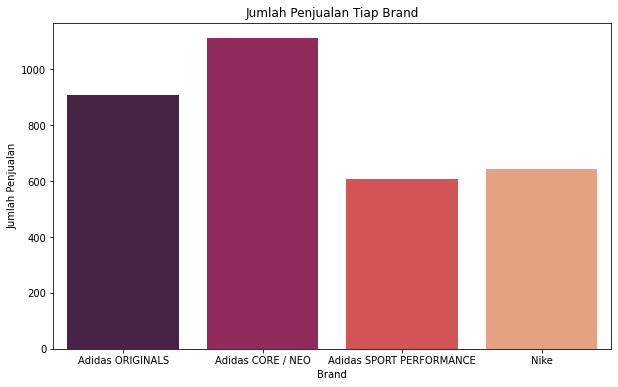

In [ ]:
# Kondisi penjualan tiap brand
plt.figure(figsize=(10,6))
sns.countplot(x="Brand", data=product_data, palette="rocket")
plt.title("Jumlah Penjualan Tiap Brand")
plt.xlabel("Brand")
plt.ylabel("Jumlah Penjualan")
plt.show()

Dari visualisasi diatas diketahui bahwa dalam store dengan kategori produk sport & apparel terdapat 2 brand yang dijual yaitu Adidas dan Nike dengan total penjualan Brand Adidas lebih tinggi dibandingkan dengan Nike. Penjualan paling banyak terdapat pada Adidas Core/Neo.
<br>
<br>
**Apakah ada kaitannya dengan pemberian diskon?**
<br>
Dikarenakan terdapat selisih yang sangat jauh antara kedua brand maka akan dicari tahu faktor lain yang mungkin mempengaruhi, salah satunya adalah pemberian diskon.

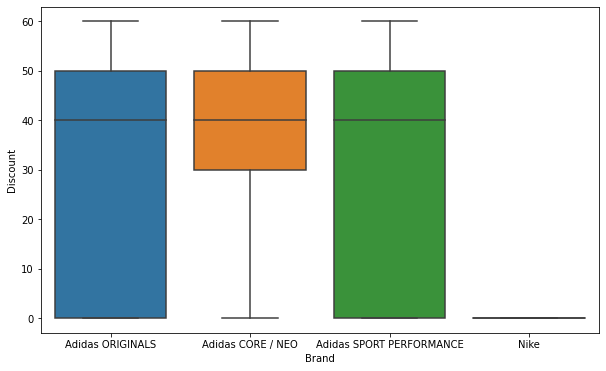

In [ ]:
# Distribusi persebaran diskon pada masing-masing brand
plt.figure(figsize=(10,6))
sns.boxplot(x="Brand", y="Discount", data=product_data)

Setelah dilakukan pengecekan penawaran yaitu adanya diskon, ternyata didapat pengaruh yang besar mengenai perbedaan perilaku customer terhadap penawaran yang diberikan. Brand adidas menawarkan diskon hampir disemua kategori produknya, berbeda dengan Nike yang tidak banyak memberikan penawaran tambahan. Hal ini mengindikasikan bahwa pemberian diskon dapat menarik minat customer.
<br>
<br>
**Namun bagaimana dengan harga yang ditawarkan? Apakah terdapat selisih yang cukup besar?**
<br>
Selanjutnya akan dicari tahu mengenai perbedaan harga pada masing-masing brand, apakah sebelum dan sesudah diskon selisih harga cukup jauh.

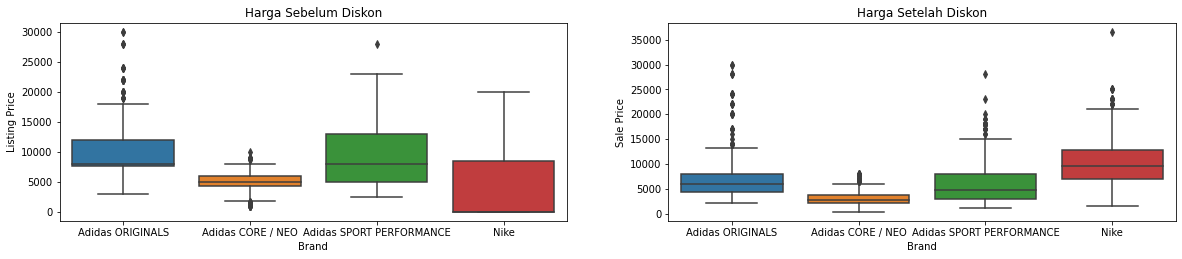

In [ ]:
# Cek Perbedaan Harga sebelum dan sesudah diskon
plt.figure(figsize=(20,8))
plt.subplot(221)
sns.boxplot(x="Brand", y="Listing Price", data=product_data)
plt.title("Harga Sebelum Diskon")
plt.subplot(222)
sns.boxplot(x="Brand", y="Sale Price", data=product_data)
plt.title("Harga Setelah Diskon")
plt.show()

Jika dilihat dari visualisasi selisih harga sebenenarnya antara Adidas dan Nike tidak berbeda cukup jauh, bahkan dibeberapa produk Adidas memiliki harga yang lebih tinggi dibandingkan dengan Nike. Namun setelah adanya diskon perbedaan harga sangat jauh berbeda, turun hingga 50% terutama pada brand adidas, sedangkan Nike masih mempertahankan harga aslinya. Sekarang akan dilakukan analisa mengenai tiap-tiap produk dan penilaian dari customer.
<br>
<br>
**Berapa banyak tipe produk pada masing-masing brand?**
<br>
Dalam strategi penjualan ada beberapa tipe strategi yang digunakan, salah duanya adalah dengan melimitasi jenis produk dan memperbanyak jenis produk. dibawah ini akan dicari tahu strategi mana yang digunakan tiap brand?

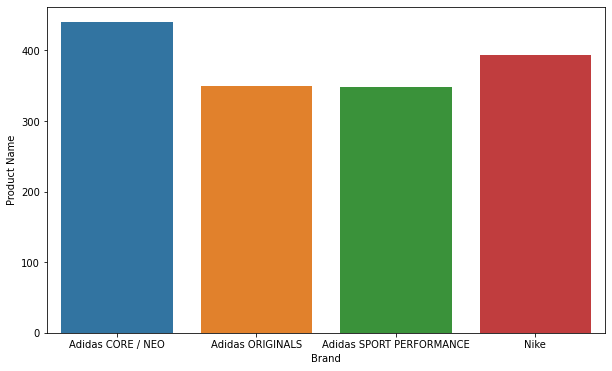

In [ ]:
# Mendapatkan banyaknya tipe produk pada masing-masing brand
total_product = product_data.groupby(["Brand", "Product Name"])["Product ID"].count().reset_index()
total_product.rename(columns = {'Product ID': 'Total Produk'}, inplace = True)

total_product = total_product.groupby("Brand")["Product Name"].count().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data = total_product, x = 'Brand', y = 'Product Name')

Berdasarkan total produk, adidas memiliki banyak variasi produk sedangkan nike lebih membatasi produknya, dengan melihat strategi ini maka nike menggunakan strategi untuk tidak memperbanyak series pada produk dan strategi ini terbukti cukup efektif untuk tetap eksis dipasaran. Walaupun nike tidak memberikan banyak penawaran kepada customer, Peminat produk nike masih cukup banyak, mempertahan stok Nike tidak akan membuat kerugian.
<br>
<br>
**Lalu bagaimana dengan penilaian dari customer pada masing-masing product?**
<br>
Penilaian customer akan dilihat dari 2 faktor, yaitu jumlah review dan pemberian rating.

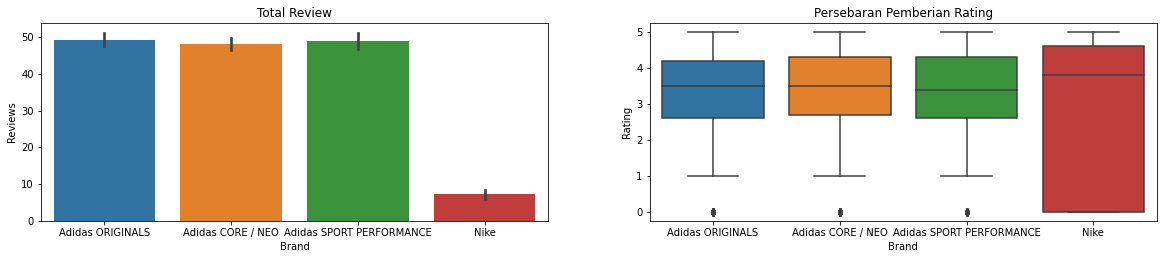

In [ ]:
# Cek Review dan Rating
plt.figure(figsize=(20,8))
plt.subplot(221)
sns.barplot(x="Brand", y="Reviews", data=product_data)
plt.title("Total Review")
plt.subplot(222)
sns.boxplot(x="Brand", y="Rating", data=product_data)
plt.title("Persebaran Pemberian Rating")
plt.show()

Jika dilihat berdasarkan jumlah review yang diberikan dan total penjualan, Adidas memiliki banyak review dari customer dengan penilaian yang cukup memuaskan yaitu dominan di rating > 2. Kondisi ini berbeda dengan Nike, disamping setidikitnya jumlah review yang diberikan, penilaian akan brand Nike lebih bervariasi, beberapa orang merasa puas dan beberapa diantaranya memberikan penilaian yang kurang memuasakan.
<br>
<br>
Melihat analisa diatas, maka banyaknya penjualan pada brand Adidas bukan hanya dipengaruhi oleh pemberian penawaran saja, namun karena pengaruh strategi yang diterapkan dan juga kualitas yang ditawarkan.

## Data Preprocessing

### Encode Categorical

In [ ]:
# Merubah data kategori menjadi numerik
label_encoder = LabelEncoder()
encoded_data = product_data[['Brand']].apply(label_encoder.fit_transform)

# Menggabungkan kedua data
cluster_data = pd.concat([encoded_data, product_data[["Listing Price", "Sale Price", 'Discount', 'Rating', 'Reviews']]], axis=1)

cluster_data.head()

,Brand,Listing Price,Sale Price,Discount,Rating,Reviews
0,1,14999,7499,50,4.8,41
1,1,7599,3799,50,3.3,24
2,0,999,599,40,2.6,37
3,0,6999,3499,50,4.1,35
4,1,7999,3999,50,3.5,72


### Features Selection
Dalam proses ini akan dipilih variabel yang memiliki pengaruh besar dalam penentuan cluster data.

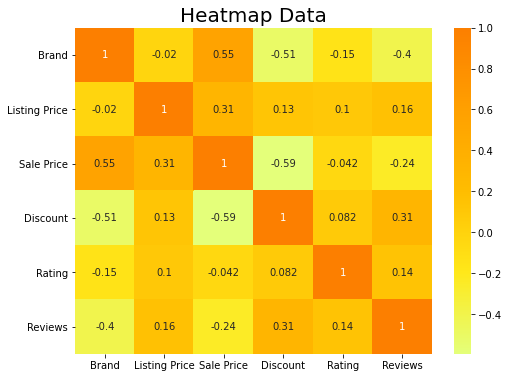

In [ ]:
# Features Selection
plt.figure(figsize=(8,6))
sns.heatmap(cluster_data.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap Data', fontsize = 20)
plt.show()

Dari hasil heatmap diatas diketahui bahwa terdapat korelasi negatif pada beberapa variabel, korelasi negatif paling banyak terjadi di variabel brand dan juga sale price. Oleh karena itu kedua variabel tersebut akan direduksi dan tidak dimasukkan dalam input clustering.

In [ ]:
# Drop variabel yang tidak dibutuhkan
cluster_data = cluster_data.drop(["Sale Price", "Brand"], axis = 1)
cluster_data.head()

,Listing Price,Discount,Rating,Reviews
0,14999,50,4.8,41
1,7599,50,3.3,24
2,999,40,2.6,37
3,6999,50,4.1,35
4,7999,50,3.5,72


### Scaling Data
Dalam clustering penggunaan scaling data juga diperlukan, hal ini akan membantu mengatasi permasalahan gap pada tiap kolom.

In [ ]:
# Membuat variabel untuk mendefinisikan variabel
columns_name = cluster_data.columns
columns_name

Index(['Listing Price', 'Discount', 'Rating', 'Reviews'], dtype='object')

In [ ]:
# Data Scaling
scaler = StandardScaler()
cluster_data[columns_name] = scaler.fit_transform(cluster_data[columns_name])
cluster_data.head()

,Listing Price,Discount,Rating,Reviews
0,1.721230,1.021839,1.090476,0.014214
1,0.154740,1.021839,0.040524,-0.524807
2,-1.242400,0.579948,-0.449453,-0.112615
3,0.027727,1.021839,0.600498,-0.176029
4,0.239415,1.021839,0.180518,0.997134


## KMeans Cluster

### Menentukan Nilai Optimal K (kelompok)

Akan digunakan metode Elbow untuk menentukan jumlah k optimal.

In [ ]:
# Perulangan ini digunakan untuk mengeksekusi nilai k dengan data 
# Selanjutkan akan dicari SSE

Sum_of_squared_error = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_data)
    Sum_of_squared_error.append(km.inertia_)

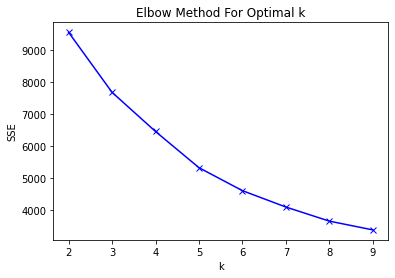

In [ ]:
plt.plot(K, Sum_of_squared_error, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

Berdasarkan metode elbow titik siku-siku diperoleh di k=3. Untuk memastikan, akan digunakan silhouette score untuk memvalidasi nilai k yang optimal.

### Evaluation Model

Menggunakan silhouette score untuk konfirmasi k-kluster

In [ ]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    centers = clusterer.cluster_centers_

    score = silhouette_score(cluster_data, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.3029585091723103
For n_clusters = 3, silhouette score is 0.3262586114575535
For n_clusters = 4, silhouette score is 0.3170450563786626
For n_clusters = 5, silhouette score is 0.2959609808676315
For n_clusters = 6, silhouette score is 0.3135025836176311
For n_clusters = 7, silhouette score is 0.31426142287606496
For n_clusters = 8, silhouette score is 0.32927709459510884
For n_clusters = 9, silhouette score is 0.33977577066608683


Dari silhouette model didapat k-kluster yang optimum adalah 3, sama seperti pemilihan cluster dengan elbow method. Score pada k=8 dan k=9 memiliki score yang tinggi, namun pembagian kelompok menjadi 8 atau 9 terlalu banyak. Oleh karena itu dipilih k=3.

In [ ]:
# Memodelkan data dengan k-means
cluster = KMeans(n_clusters=3)
cluster.fit(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Membuat kolom baru berdasarkan hasil clustering
segment = pd.Series(cluster.labels_, name="segment")

In [ ]:
# Menggabungkan data dengan hasil cluster
results = pd.concat([product_data, segment], axis=1)
results.head()

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited\t,segment
0,Women's adidas Originals NMD_Racer Primeknit S...,AH2430,14999,7499,50,Adidas ORIGINALS,Channeling the streamlined look of an '80s rac...,4.8,41,2020-04-13T15:06:14\t,0
1,Women's adidas Originals Sleek Shoes,G27341,7599,3799,50,Adidas ORIGINALS,"A modern take on adidas sport heritage, tailor...",3.3,24,2020-04-13T15:06:15\t,0
2,Women's adidas Swim Puka Slippers,CM0081,999,599,40,Adidas CORE / NEO,These adidas Puka slippers for women's come wi...,2.6,37,2020-04-13T15:06:15\t,0
3,Women's adidas Sport Inspired Questar Ride Shoes,B44832,6999,3499,50,Adidas CORE / NEO,"Inspired by modern tech runners, these women's...",4.1,35,2020-04-13T15:06:15\t,0
4,Women's adidas Originals Taekwondo Shoes,D98205,7999,3999,50,Adidas ORIGINALS,This design is inspired by vintage Taekwondo s...,3.5,72,2020-04-13T15:06:15\t,0


## EDA
Selanjutnya akan dicari tahu karakteristik dari tiap cluster.
<br>
<br>
**Bagaimana persebaran brand pada tiap cluster ?**

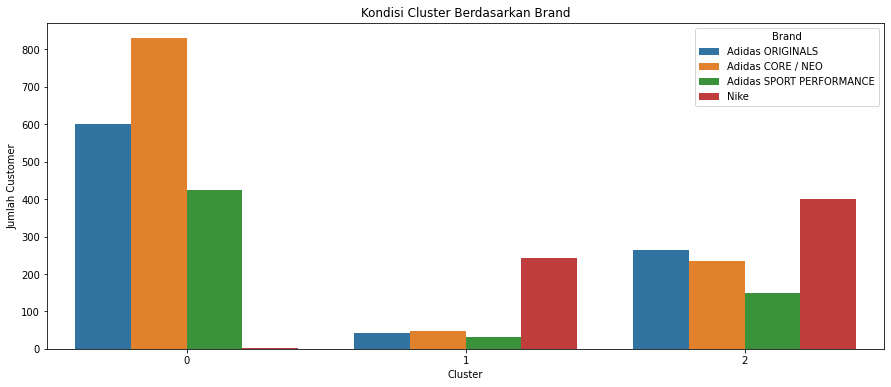

In [ ]:
# Persebaran Brand pada tiap cluster
plt.figure(figsize=(15,6))
sns.countplot(x="segment", data=results, hue="Brand")
plt.title("Kondisi Cluster Berdasarkan Brand")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

Cluster 0 hanya terdiri dari brand Adidas dan Nike yang sangat sedikit, sedangkan pada cluster 1 dan 2 terdiri dari campuran antara brand adidas dan Nike dengan jumlah Nike lebih banyak dibanding tipe brand lainnya.
<br>
<br>
**Lalu bagaimana series produk pada tiap cluster?**

In [ ]:
# Memfilter data dengan kategori segment, brand, dan product name
series_cluster = results.groupby(["segment", "Brand", "Product Name"])["Product ID"].count().reset_index()
series_cluster.rename(columns = {'Product ID': 'Total Produk'}, inplace = True)
series_cluster

,segment,Brand,Product Name,Total Produk
0,0,Adidas CORE / NEO,MEN'S ADIDAS CLOUDFOAM RACER TR SHOES,1
1,0,Adidas CORE / NEO,MEN'S ADIDAS RUN 70S SHOES,1
2,0,Adidas CORE / NEO,MEN'S ADIDAS RUNNING 8K SHOES,1
3,0,Adidas CORE / NEO,MEN'S ADIDAS RUNNING ADISTARK 3.0 SHOES,2
4,0,Adidas CORE / NEO,MEN'S ADIDAS RUNNING ARGECY SHOES,2
...,...,...,...,...
1764,2,Nike,PG 3,2
1765,2,Nike,PG 3 NASA,2
1766,2,Nike,PG 4 EP,1
1767,2,Nike,Zoom Freak 1,1


In [ ]:
# Mengelompokkan data dengan unique value
series_cluster = series_cluster.groupby(["segment", "Brand"])["Product Name"].count().reset_index()
series_cluster

,segment,Brand,Product Name
0,0,Adidas CORE / NEO,337
1,0,Adidas ORIGINALS,257
2,0,Adidas SPORT PERFORMANCE,250
3,0,Nike,1
4,1,Adidas CORE / NEO,46
5,1,Adidas ORIGINALS,34
6,1,Adidas SPORT PERFORMANCE,29
7,1,Nike,165
8,2,Adidas CORE / NEO,143
9,2,Adidas ORIGINALS,131


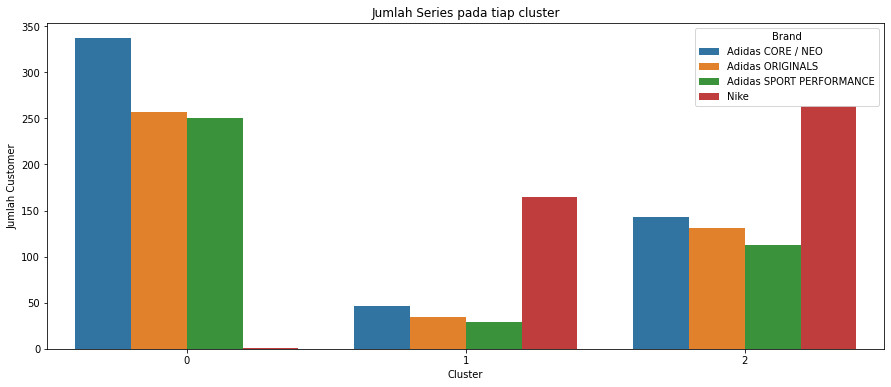

In [ ]:
# Banyaknya series produk pada tiap cluster
plt.figure(figsize=(15,6))
sns.barplot(x="segment", y = "Product Name", data=series_cluster, hue="Brand")
plt.title("Jumlah Series pada tiap cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

Ada perbedaan yang cukup mencolok apabila dilihat dari jumlah series produk. Dari visualisasi diatas diketahui bahwa :
- Cluster 0 : Series yang di tawarkan lebih banyak dibanding cluster lainnya.
- Cluster 1 : Dalam cluster ini series yang ditawarkan sangat terbatas dibanding lainnya
- Cluster 2 : Pada cluster ini, series produk cukup banyak yang ditawarkan.


Melihat analisa cluster dengan 2 variabel sebelumnya, maka akan dicari tahu **Berapa harga yang ditawarkan pada masing-masing cluster?**

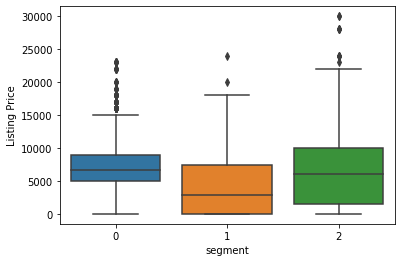

In [ ]:
# Pengelompokan cluster berdasarkan harga
sns.boxplot(x=results["segment"], y=results["Listing Price"], data=results)

Berdasarkan harga yang ditawarkan, range harga tertinggi ada pada cluster 2, disusul dengan cluster 1 kemudian 0.

**Bagaimana dengan pemberian diskon pada masing-masing cluster?**

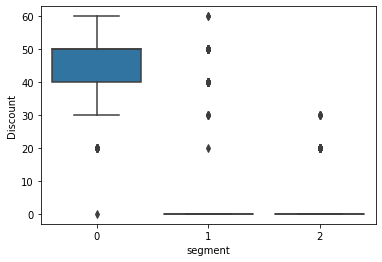

In [ ]:
# Pengelompokan cluster berdasarkan diskon
sns.boxplot(x=results["segment"], y=results["Discount"], data=results)

Jika dilihat berdasarkan pemberian diskon
- cluster 0 menawarkan banyak diskon
- cluster 1 terdapat beberapa produk yang ditawarkan diskon dengan nilai proprosi yang tinggi
- cluster 2 sangat minim penawaran diskon, ada beberapa produk yang ditawarkan diskon namun dengan proporsi yang rendah.


**Bagaimana dengan kondisi favorite product pada tiap cluster?**
<br>
Produk favorit akan dilihat berdasarkan rating yang diberikan customer

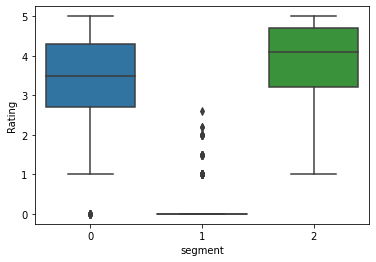

In [ ]:
# Kondisi cluster berdasarkan rating
sns.boxplot(x=results["segment"], y=results["Rating"], data=results)

Dari analisa berdasarkan rating, cluster 1 adalah cluster dimana hanya beberapa orang yang merasa puas dengan barang, sedangkan cluster lainnya rata-rata customer sangat puas dengan produk yang mereka beli.
<br>
<br>
Melihat hubungan 2 variabel

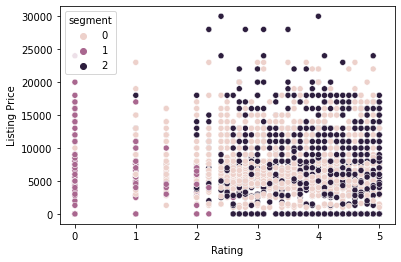

In [ ]:
# Hubungan harga dengan rating
sns.scatterplot(x="Rating", y="Listing Price", hue = "segment", data=results)

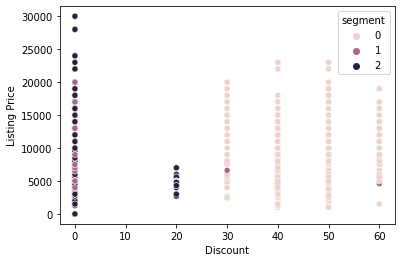

In [ ]:
# Hubungan harga dengan diskon
sns.scatterplot(x="Discount", y="Listing Price", hue = "segment", data=results)

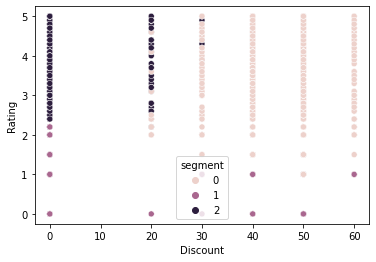

In [ ]:
# Hubungan rating dengan diskon
sns.scatterplot(x="Discount", y="Rating", hue = "segment", data=results)

Terdapat beberapa faktor yang mempengaruhi pemberian diskon, salah satunya dikarenakan product tersebut sudah berada lama dalam gudang atau dengan kata lain bukan produk terbaru.

Dengan menimbang analisa sebelumnya maka dapat ditarik kesimpulan untuk pembagian pengelompokkan produk
- Cluster 0 akan dikelompokkan kedalam **Produk Dalam Diskon**, product ini terdiri dari produk dengan keluaran lama namun masih banyak peminat, pemberian diskon memberikan impact yang positif dari segi penjualan.
- Cluster 1 dikelompokan kedalam **Produk Terbaru**, produk dalam kategori ini adalah produk yang kurang banyak diminati dan memiliki reputasi yang kurang bagus, dengan harga yang tinggi dan tidak di bantu dengan penawaran lainnya walaupun keluaran yang cukup baru namun tingkat penjualan rendah.
- Cluster 2 dikelompokan kedalam **Produk Favorit**, kelompok ini merupakan kategori produk unggulan, walaupun produk dibrandrol dengan harga yang tinggi dan tanpa penawaran dari segi pemberian diskon, namun respon customer masih sangat bagus, dan record penjualan sangat memuaskan.
